# Импорт

In [ ]:
!pip install stanza
!pip install pymorphy2
!pip install transformers
!pip install datasets
!pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 29.7 MB/s 
     |████████████████████████████████| 240 kB 65.0 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=50bb5b3c16369b2581d2c83987d937e2de1b90dc8c5250dc0d8fcd68f5abf33f
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 8.2 MB 22.9 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=cad098a241506f7cfa1bd0a6f86e6b2bb1f9f035363bae68482b323636f255bd
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
Look

In [ ]:
import pandas as pd
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
import stanza
import re
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import LabelEncoder
import sklearn_crfsuite
from sklearn_crfsuite import metrics as crf_metrics
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adagrad, AdamW
le = LabelEncoder()
stanza.download('ru')

INFO:stanza:Downloading default packages for language: ru (Russian) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


# Задание 1 (Выделение эксплицитных аспектов)

### Если не хочется брать некоторые файлы из гитхаба:

In [ ]:
texts, ids = [], []
with open('train_reviews.txt') as f:
    for line in f:
        text_id, text = line.rstrip('\r\n').split('\t')
        texts.append(text)
        ids.append(text_id)

In [ ]:
train_texts, dev_texts, train_ids, dev_ids = train_test_split(texts, ids)
train_aspects, dev_aspects = [], []
with open('train_aspects.txt') as f:
    for line in f:
        line = line.rstrip('\r\n')
        text_id = line.split('\t')[0]
        if text_id in train_ids:
            train_aspects.append(line)
        if text_id in dev_ids:
            dev_aspects.append(line)

In [ ]:
train_sentiment, dev_sentiment = [], []
with open('train_cats.txt') as f:
    for line in f:
        line = line.rstrip('\r\n')
        text_id = line.split('\t')[0]
        if text_id in train_ids:
            train_sentiment.append(line)
        if text_id in dev_ids:
            dev_sentiment.append(line)

In [ ]:
with open('train_split_aspects.txt', 'w') as f:
    for l in train_aspects:
        print(l, file=f)
with open('dev_aspects.txt', 'w') as f:
    for l in dev_aspects:
        print(l, file=f)
with open('train_split_reviews.txt', 'w') as f:
    for i, l in zip(train_ids, train_texts):
        print(i, l, sep="\t", file=f)
with open('dev_reviews.txt', 'w') as f:
    for i, l in zip(dev_ids, dev_texts):
        print(i, l, sep="\t", file=f)
with open('train_split_cats.txt', 'w') as f:
    for l in train_sentiment:
        print(l, file=f)
with open('dev_cats.txt', 'w') as f:
    for l in dev_sentiment:
        print(l, file=f)

### Читаем файлы

In [ ]:
train_asp = pd.read_csv(
    'train_split_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_split_reviews.txt', delimiter='\t', names=['text_id','text'])

Для выделения BIO будем использовать stanza, как в примере

In [ ]:
nlp = stanza.Pipeline('ru', processors='tokenize,pos')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!


In [ ]:
morph = MorphAnalyzer()

In [ ]:
reviews = {}
with open('train_split_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    reviews[line[0]] = line[1]

In [ ]:
aspects = dict()
with open('train_split_aspects.txt') as f:
    for line in f:
        line = line.rstrip('\r\n').split('\t')
        keys = ('category', 'mention', 'start', 'end', 'sentiment')
        if line[0] not in aspects:
          aspects[line[0]] = []
        aspects[line[0]].append(dict(zip(keys, line[1:])))

In [ ]:
print(aspects)

{'3976': [{'category': 'Whole', 'mention': 'ресторане', 'start': '71', 'end': '80', 'sentiment': 'neutral'}, {'category': 'Whole', 'mention': 'ресторанах', 'start': '198', 'end': '208', 'sentiment': 'neutral'}, {'category': 'Whole', 'mention': 'ресторане', 'start': '256', 'end': '265', 'sentiment': 'neutral'}, {'category': 'Service', 'mention': 'Столик бронировали', 'start': '267', 'end': '285', 'sentiment': 'neutral'}, {'category': 'Service', 'mention': 'администратор', 'start': '322', 'end': '335', 'sentiment': 'positive'}, {'category': 'Service', 'mention': 'предварительный заказ', 'start': '349', 'end': '370', 'sentiment': 'positive'}, {'category': 'Whole', 'mention': 'ресторан', 'start': '413', 'end': '421', 'sentiment': 'neutral'}, {'category': 'Whole', 'mention': 'ресторане', 'start': '476', 'end': '485', 'sentiment': 'neutral'}, {'category': 'Food', 'mention': 'горячее блюдо', 'start': '524', 'end': '537', 'sentiment': 'neutral'}, {'category': 'Food', 'mention': 'Меню', 'start'

In [ ]:
def bio_ing(reviews):
    bio_texts = []
    for text_id, text in tqdm(reviews.items()):
        doc = nlp(text)
        bio = []
        for token in doc.iter_tokens():
            check = 0
            for mention in aspects[text_id]:
                info = {
                    'text': '',
                    'pos': '',
                    'bio_tag': '',
                    'text_id': '',
                    'start': '',
                    'end': '',
                    'sentiment': ''
                }
                if token.start_char == int(mention['start']) and token.end_char <= int(mention['end']):
                    info['bio_tag'] = f"B-{mention['category']}"
                elif token.start_char > int(mention['start']) and token.end_char <= int(mention['end']):
                    info['bio_tag'] = f"I-{mention['category']}"
                if info['bio_tag'] != '':
                    info['text'] = token.text
                    info['pos'] = token.words[0].pos if token.words[0].pos is not None else 'PUNKT'
                    info['text_id'] = text_id
                    info['start'] = token.start_char
                    info['end'] = token.end_char
                    info['sentiment'] = mention['sentiment']
                    bio.append(info)
                    check = 1
            if check == 0:
                bio.append({
                    'text': token.text,
                    'pos': token.words[0].pos if token.words[0].pos is not None else 'PUNKT',
                    'bio_tag': 'O',
                    'text_id': text_id,
                    'start': token.start_char,
                    'end': token.end_char,
                    'sentiment': '-'
                })
        bio_texts.append(bio)
    return bio_texts

In [ ]:
bio_reviews = bio_ing(reviews)

100%|██████████| 213/213 [06:03<00:00,  1.71s/it]


In [ ]:
train_reviews, test_reviews = train_test_split(bio_reviews)

In [ ]:
def word2features(sent, i):
    word = sent[i]['text']
    pos_tag = sent[i]['pos']
    text_id = sent[i]['text_id']
    start_position = sent[i]['start']
    end_position = sent[i]['end']
    
    features = {
        'text_id': text_id,
        'text': word,
        'start_pos': start_position,
        'end_pos': end_position,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'pos_tag': pos_tag,
        'pos_tag[:2]': pos_tag[:2],
    }
    if i > 0:
        word1 = sent[i-1]['text']
        pos_tag1 = sent[i-1]['pos']
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:pos_tag': pos_tag1,
            '-1:pos_tag[:2]': pos_tag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]['text']
        pos_tag1 = sent[i+1]['pos']
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:pos_tag': pos_tag1,
            '+1:pos_tag[:2]': pos_tag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word['bio_tag'] for word in sent]

def sent2tokens(sent):
    return [word['text'] for word in sent]

In [ ]:
print(train_reviews[0][0])

{'text': 'Кухня', 'pos': 'NOUN', 'bio_tag': 'B-Food', 'text_id': '37220', 'start': 0, 'end': 5, 'sentiment': 'positive'}


In [ ]:
X_train = [sent2features(text) for text in train_reviews]
y_train = [sent2labels(text) for text in train_reviews]

X_test = [sent2features(text) for text in test_reviews]
y_test = [sent2labels(text) for text in test_reviews]

In [ ]:
sklearn_crfsuite.CRF._get_param_names()

['algorithm',
 'all_possible_states',
 'all_possible_transitions',
 'averaging',
 'c',
 'c1',
 'c2',
 'calibration_candidates',
 'calibration_eta',
 'calibration_max_trials',
 'calibration_rate',
 'calibration_samples',
 'delta',
 'epsilon',
 'error_sensitive',
 'gamma',
 'keep_tempfiles',
 'linesearch',
 'max_iterations',
 'max_linesearch',
 'min_freq',
 'model_filename',
 'num_memories',
 'pa_type',
 'period',
 'trainer_cls',
 'variance',
 'verbose']

In [ ]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [ ]:
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
y_pred  = crf.predict(X_test)

In [ ]:
labels = set()
for y_big in y_train:
  for y_small in y_big:
    labels.add(y_small)

labels = list(labels)

In [ ]:
crf_metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9222557544526798

In [ ]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(crf_metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           O      0.947     0.981     0.964      8250
      B-Food      0.766     0.648     0.702       358
      I-Food      0.763     0.535     0.629       217
  B-Interior      0.796     0.517     0.627       143
  I-Interior      0.412     0.175     0.246        40
     B-Price      0.875     0.519     0.651        27
     I-Price      0.000     0.000     0.000        13
   B-Service      0.827     0.614     0.704       233
   I-Service      0.560     0.359     0.438        39
     B-Whole      0.742     0.648     0.692       142
     I-Whole      0.464     0.591     0.520        22

    accuracy                          0.928      9484
   macro avg      0.650     0.508     0.561      9484
weighted avg      0.921     0.928     0.922      9484



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
crf_preds = [prediction for prediction in y_pred]
true_labels = [true_label for true_label in y_test]

In [ ]:
def dev_mark(y_pred, X_test):
  dev_return = {
      'text_id': [], 
      'tag': [], 
      'text': [], 
      'start': [], 
      'end': []
  }
  for num, i in enumerate(y_pred):
      for j, tag in enumerate(i):
          if tag != 'O' and i[j].startswith('B') and i[j + 1].startswith('I'):
              n = j + 1
              tokens = []
              tokens.append(X_test[num][j]['text'])
              start = X_test[num][j]['start_pos']
              while i[n].startswith('I'):
                  tokens.append(X_test[num][n]['text'])
                  n += 1
              end = X_test[num][n-1]['end_pos']
              t_id = X_test[num][j]['text_id']
              tag = i[j].split('-')[1]
              dev_return['text_id'].append(t_id)
              dev_return['text'].append(' '.join(tokens))
              dev_return['tag'].append(tag)
              dev_return['start'].append(start)
              dev_return['end'].append(end)
          elif tag != 'O' and i[j].startswith('B') and not i[j + 1].startswith('I'):
              dev_return['text_id'].append(X_test[num][j]['text_id'])
              dev_return['tag'].append(i[j].split('-')[1])
              dev_return['text'].append(X_test[num][j]['text'])
              dev_return['start'].append(X_test[num][j]['start_pos'])
              dev_return['end'].append(X_test[num][j]['end_pos'])
  df = pd.DataFrame(dev_return)
  return df

In [ ]:
dev_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id', 'text'])

In [ ]:
dev_reviews = {}
with open('dev_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    dev_reviews[line[0]] = line[1]

In [ ]:
def get_data(dev_reviews):
  all_texts = []
  for text_id, text in tqdm(dev_reviews.items()):
    tokens = []
    processed = nlp(text)
    for token in processed.iter_tokens():
      parse = morph.parse(token.text)[0]
      postag = parse.tag.POS
      if postag is None:
        postag = 'PUNKT'
      tokens.append({'text':token.text, 'pos':postag, 'text_id':text_id,
                     'start':token.start_char, 'end':token.end_char})
    all_texts.append(tokens)
  return all_texts

In [ ]:
all_texts = get_data(dev_reviews)

100%|██████████| 71/71 [01:50<00:00,  1.56s/it]


In [ ]:
test_data = [sent2features(text) for text in all_texts]
dev_pred = crf.predict(test_data)
dev_res = dev_mark(dev_pred, test_data)

In [ ]:
with open('dev_pred_aspects.txt', 'w') as file:
  for text_id, tag, text, start, end in zip(dev_res['text_id'], dev_res['tag'], dev_res['text'], dev_res['start'], dev_res['end']):
      print(text_id, tag, text, start, end, sep="\t", file=file)

Получившиеся данные

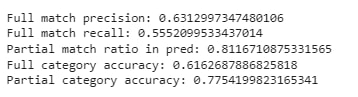

In [ ]:
import pickle
pkl_filename = "crf_model.pkl" 
with open(pkl_filename, 'wb') as file: 
  pickle.dump(crf, file)

# Задание 2 (Оценка тональности по аспектам)

In [ ]:
!python3 -m spacy download ru_core_news_md

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-28 08:43:48.457877: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.9 MB 2.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


In [ ]:
import pandas as pd
train_reviews = pd.read_csv('train_reviews.txt', sep='\t', names=['review_id', 'text'], header=None)
train_aspects = pd.read_csv('train_split_aspects.txt', sep='\t', names=['review_id', 'category', 'span', 'span_start', 'span_end', 'sentiment'], header=None)

In [ ]:
import spacy
import re
from tqdm.notebook import tqdm
tqdm.pandas()

def get_dependencies(text, review_id):
  all_tokens = []
  doc = nlp(text)
  for token in doc:
    all_tokens.append([review_id, token.text, token.pos_, token.dep_, [child for child in token.children if child.pos_ in ['ADJ', 'NOUN', 'VERB', 'PART']], token.head.text, token.idx, token.idx+len(token.text)]) 
  global result_spacy
  result_spacy.append(all_tokens)

result_spacy = []
nlp = spacy.load("ru_core_news_md")
train_reviews.progress_apply(lambda x: get_dependencies(x['text'], x['review_id']), axis=1)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


  0%|          | 0/284 [00:00<?, ?it/s]

0      None
1      None
2      None
3      None
4      None
       ... 
279    None
280    None
281    None
282    None
283    None
Length: 284, dtype: object

Сопоставляем по индексам с нашим исходником, собираем импровизированный чанк



In [ ]:
def find_for_train(span, start, end, review_id):
  s = span
  for i in range(0, len(result_spacy)):
      for j in range(0, len(result_spacy[i])):
        if review_id == result_spacy[i][j][0] and span == result_spacy[i][j][1] and start == result_spacy[i][j][6] and end == result_spacy[i][j][7]:
          s = result_spacy[i][j][5] + ' ' + result_spacy[i][j][1]
          if type(result_spacy[i][j][4]) == list:
            for x in result_spacy[i][j][4]:
              s = s + ' ' + x.text
          if type(result_spacy[i][j][4]) == str:
              s = s + ' ' + result_spacy[i][j][4].text

  return s
      

train_aspects['chunk'] = train_aspects.progress_apply(lambda x: find_for_train(x['span'], x['span_start'], x['span_end'], x['review_id']), axis=1)

  0%|          | 0/3618 [00:00<?, ?it/s]

# Обучение

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Берем несколько моделей для экспериментов

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report

In [ ]:
dev_aspects = pd.read_csv('dev_pred_aspects.txt', sep='\t', names=['review_id', 'category', 'span', 'span_start', 'span_end', 'sentiment'], header=None)

### Получаем вектора LaBSE

In [ ]:
def get_embeddings_LaBSE(texts, tokenizer_LaBSE, model_LaBSE):
  tokenizer_LaBSE = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
  model_LaBSE = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
  encoded_input = tokenizer_LaBSE(texts, padding=True, truncation=True, return_tensors='pt')
  with torch.no_grad():
      model_output = model_LaBSE(**encoded_input)
  embeddings_LaBSE = model_output.pooler_output
  embeddings_LaBSE = torch.nn.functional.normalize(embeddings_LaBSE)
  return embeddings_LaBSE


tokenizer_LaBSE = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model_LaBSE = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/521k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Получаем вектора для наших собранных чанков

Особого различия в зависимости от модели для векторизации не замечено, возьмем LaBSE

In [ ]:
dev_aspects['chunk'] = dev_aspects.progress_apply(lambda x: find_for_train(x['span'], x['span_start'], x['span_end'], x['review_id']), axis=1)

  0%|          | 0/963 [00:00<?, ?it/s]

In [ ]:
embeddings_labse_chunk = get_embeddings_LaBSE(list(train_aspects['chunk']), model_LaBSE, tokenizer_LaBSE)
embeddings_labse_dev_chunk = get_embeddings_LaBSE(list(dev_aspects['chunk']), model_LaBSE, tokenizer_LaBSE)

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.pr

In [ ]:
model_xgb = XGBClassifier(max_depth=3, n_estimators=100)
model_xgb.fit(embeddings_labse_chunk, list(train_aspects['sentiment']))
y_pred = model_xgb.predict(embeddings_labse_dev_chunk)

In [ ]:
import pickle
pkl_filename = "xgb_labse.pkl" 
with open(pkl_filename, 'wb') as file: 
  pickle.dump(model_xgb, file)

Accuracy наконец-то изменилось в большую сторону, сохраняем

In [ ]:
dev_aspects['sentiment'] = y_pred
dev_aspects = dev_aspects.drop(columns=['chunk'])
dev_aspects.to_csv('dev_pred_aspects.txt', sep = '\t', index=False, header=False)

#### Предсказываем категории 

In [ ]:
!pip install navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

from navec import Navec
from string import punctuation

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

cats = ['Whole', 'Interior', 'Service', 'Food', 'Price']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-12-28 09:04:26--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  18.4MB/s    in 2.7s    

2022-12-28 09:04:30 (18.4 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
!wget train_aspects.txt https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_split_aspects.txt

train_aspects = pd.read_csv('train_split_aspects.txt', sep='\t', names=['review_id', 'category', 'span', 'span_start', 'span_end', 'sentiment'], header=None)

--2022-12-28 09:04:30--  http://train_aspects.txt/
Resolving train_aspects.txt (train_aspects.txt)... failed: Name or service not known.
wget: unable to resolve host address ‘train_aspects.txt’
--2022-12-28 09:04:30--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_split_aspects.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170883 (167K) [text/plain]
Saving to: ‘train_split_aspects.txt.1’

train_split_aspects 100%[===================>] 166.88K  --.-KB/s    in 0.004s  

2022-12-28 09:04:31 (44.1 MB/s) - ‘train_split_aspects.txt.1’ saved [170883/170883]

FINISHED --2022-12-28 09:04:31--
Total wall clock time: 0.1s
Downloaded: 1 files, 167K in 0.004s (44.1 MB/s)


In [ ]:
cat_words = train_aspects[['category', 'span']]
cat_vectors = {}
for category in cats:
  count_words = 0
  subc = cat_words.loc[cat_words['category'] == category]['span'].tolist()
  for i in subc:
    i = i.translate(str.maketrans('', '', punctuation))
    i = i.lower().split()
    for ii in i:
      if count_words and navec.get(ii) is not None:
        cat_vectors[category] += navec[ii]
        count_words += 1
      elif navec.get(ii) is not None:
        cat_vectors[category] = navec[ii]
        count_words += 1
  cat_vectors[category] = cat_vectors[category] / count_words

In [ ]:
from scipy.spatial.distance import cosine
from random import choice

In [ ]:
def predict_category(spans, random_if_undefined=True):
  '''
    Predicts list of categories based on list of strings
  '''
  categories = []
  for i in spans:
    predicted_category = None
    i = i.translate(str.maketrans('', '', punctuation))
    i = i.lower().split()
    vec = None
    count_words = 0
    for ii in i:
      if not count_words and navec.get(ii) is not None:
        vec = navec[ii]
        count_words += 1
      elif navec.get(ii) is not None:
        vec += navec[ii]
        count_words += 1
    if count_words:
      word_vec = vec / count_words
      similarity = -1
      category = None
      for cat, cat_vec in cat_vectors.items():
          sim = 1 - cosine(cat_vec, word_vec)
          if sim > similarity:
            category = cat
            similarity = sim
    if not category and random_if_undefined:
      category = choice(cats)
    categories.append(category)

  return categories

In [ ]:
dev_aspects['predicted_category'] = predict_category(dev_aspects['span'].tolist())

In [ ]:
dev_aspects

,review_id,category,span,span_start,span_end,sentiment,predicted_category
0,27375,Interior,ресторанчик месяца,43,61,positive,Whole
1,27375,Food,закуски,146,153,positive,Food
2,27375,Interior,атмосфера,158,167,positive,Interior
3,27375,Service,персонал,181,189,positive,Service
4,27375,Service,девушка,203,210,positive,Service
...,...,...,...,...,...,...,...
958,37428,Service,обслуживанием,577,590,positive,Service
959,37428,Food,кальян,615,621,positive,Food
960,37428,Food,еду,663,666,neutral,Food
961,37428,Food,там ничего кроме сырной тарелки,680,711,negative,Food


In [ ]:
print('accuracy of category prediction:')
sum(1 for x,y in zip(dev_aspects['category'].tolist(),dev_aspects['predicted_category'].tolist()) if x == y) / float(len(dev_aspects['category'].tolist()))

accuracy of category prediction:


0.8566978193146417

In [ ]:
from collections import Counter

In [ ]:
def get_overall_tone(final_df, arbitrary_if_uncertain=False):

  cumulative_tone = pd.DataFrame(columns=['review_id', 'category', 'sentiment'])
  
  prev_review = 0
  cur_cats = {cat:False for cat in cats}
  for i in dev_aspects.groupby(['review_id', 'category'])['sentiment']:
    row = i[0]
    cur_review = row[0]
    contenders = Counter(i[1]).most_common(2)
    if prev_review != cur_review and prev_review:
      # print(prev_review, cur_review, cur_cats)
      for cat, val in cur_cats.items():
        if val is False:
          cumulative_tone.loc[len(cumulative_tone)] = [prev_review, cat, 'absence']
      cur_cats = {cat:False for cat in cats}
    if len(contenders) == 1 or arbitrary_if_uncertain:
      cumulative_tone.loc[len(cumulative_tone)] = list(row) + [contenders[0][0]]
    else:
      cumulative_tone.loc[len(cumulative_tone)] = list(row) + ['both']
    prev_review = cur_review
    cur_cats[row[1]] = True

  return cumulative_tone

In [ ]:
get_overall_tone(dev_aspects)

,review_id,category,sentiment
0,280,Food,positive
1,280,Interior,positive
2,280,Service,positive
3,280,Whole,uncertain
4,343,Food,uncertain
...,...,...,...
279,38299,Whole,positive
280,38772,Food,positive
281,38772,Interior,positive
282,38772,Service,uncertain


In [ ]:
out = get_overall_tone(dev_aspects)

In [ ]:
out.to_csv('dev_pred_categories.txt', sep='\t', header=False, index=False)